In [269]:
import pandas as pd
import numpy as np

In [282]:
MINI_TRAIN_PATH = './DATA/MiniTrain.csv'
TRAIN_PATH = './DATA/TrainData.csv'
MINI_TEST_PATH = './DATA/MiniTest.csv'
TEST_PATH = './DATA/TestData.csv'
HUNDRED = 100

In [283]:
train_data = pd.read_csv(MINI_TRAIN_PATH)
test_data = pd.read_csv(MINI_TEST_PATH)

train_data.dropna(inplace=True)
train_data.reset_index(drop=True, inplace=True)

test_data.dropna(inplace=True)
test_data.reset_index(drop=True, inplace=True)

print(train_data.shape)
print(test_data.shape)

(999, 3)
(491, 3)


In [284]:
import nltk
# from nltk.downloader import download, download_shell
# nltk.download('stopwords')
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")
import re

# Loading stopwords from nltk library
stop_words = set(stopwords.words('english'))
# Function for text preprocessing
def txt_preprocessing(total_text, index, column, df):
    if type(total_text) is not int:
        string = ""
        # Replace every special character with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # Remove multiple spaces
        total_text = re.sub('\s+',' ', total_text)
        # Converting to lowercase
        total_text = total_text.lower()
        
        for word in total_text.split():
        # If word is not a stopword then retain that word from the data
            if not word in stop_words:
                string += word + " "
        df[column][index] = string

In [285]:
for index, row in train_data.iterrows():
    if type(row['Text']) is str:
        txt_preprocessing(row['Text'], index, 'Text', train_data)

train_data.head()

,ArticleId,Text,Category
0,1833,worldcom ex boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens maj...,business
3,1976,lifestyle governs mobile choice faster better ...,tech
4,917,enron bosses 168m payout eighteen former enron...,business


In [286]:
# ind = list(data.index)
# np.random.shuffle(ind)

# train_len = int(data.shape[0]*0.80)
# train_ind = ind[:train_len]
# training_data = data.iloc[train_ind,:]
# # print(training_data.head())

# test_ind = ind[train_len:]
# testing_data = data.iloc[test_ind,:]
# # print(testing_data.head())

# print('Training_data size -> {}'.format(training_data.shape))
# print('Testing_data size -> {}'.format(testing_data.shape))

# assert data.shape[0] ==  len(train_ind)+ len(test_ind), 'Not equal distribution'

In [287]:
Category = {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}
vals = {}
weights = {}

class WeightedNB:
    def __init__(self, target, dataframe):
        self.df = dataframe
        # Target/Category Column
        self.c_n = target
        # Column Names
        self.cols = list(self.df.columns)
        self.cols.remove(self.c_n)
        
        self.store = {}
        self.likelihood_for_all_()
        
    def likelihood_cal(self, x, y, z):
        """ 
        x -> Column Name (String)
        y -> Column Value (String)
        z -> Class value (String)
        c_n -> Class Name (Target)
        
        Returns -> P(x = y | c_n = z)
        """
        df = self.df
        
        if x not in self.cols:
            raise KeyError("Feature(column) not present in the Training Dataset")
        
        res =  len(df[(df[x] == y) & (df[self.c_n] == z)]) /len(df[df[self.c_n] == z])
        
        if res == 0.0:
            return 1/(len(df[df[self.c_n] == z]) + len(df[x].unique()))
        
        return res
    
    def likelihood_for_all_(self):     
        df = self.df
        dict1 = {}
        for x in self.cols:
            dict2 = {}
            for y in df[x].unique():
                dict3 = {}
                for z in df[self.c_n].unique():
                    #print('P({}="{}"|{}="{}") = {}'.format(x,y,self.c_n,z,self.likelihood_cal(x, y, z)))
                    dict3[z] = self.likelihood_cal(x, y, z)
                dict2[y] = dict3
            dict1[x] = dict2
        
        self.store = dict1
    
    def likelihood_expr(self, class_val, expr):
        val = 1  
        
        for k,v in expr:
            try:
                store_val = self.store[k][v][class_val]
            except:
                store_val = self.likelihood_cal(k,v,class_val)
                
            val *= store_val
                                         
        return val
    
    def prior(self, class_val):
        df = self.df
        return len(df[df[self.c_n] == class_val])/df.shape[0]
    
    def train(self, X):
        df = self.df
        
        if type(X) == pd.core.series.Series:
            values_list = [list(X.items())]
            
        elif type(X) == pd.core.frame.DataFrame:
            values_list = [list(y.items()) for x,y in X.iterrows()]
            
        else:
            raise TypeError('{} is not supported type'.format(type(X)))
            
        
        for text in values_list:
            article = list(text[1])[1]
            category = list(text[2])[1]
            words = article.split(' ')
            for word in words:
                if word in vals:
                    vals[word][Category[category]] = vals[word][Category[category]] + 1
                else:
                    vals[word] = [0,0,0,0,0]
                    vals[word][Category[category]] = 1
                    
        for values in vals:
            total = sum(vals[values])
            for i in range(5):
                vals[values][i] = vals[values][i]/total
        
        for values in vals:
            weights[values] = np.array(vals[values])
            for i in range(5):
                if (sum(vals[values]) - vals[values][i]) != 0.0 and vals[values][i] != 0.0:
                    weights[values][i] = np.exp(np.log(vals[values][i] / (sum(vals[values]) - vals[values][i])))
                else:
                    weights[values][i] = 0.0
                    
        
    def predict(self, X):
        predicted_values = []
        if type(X) == pd.core.series.Series:
            values_list = [list(X.items())]
            
        elif type(X) == pd.core.frame.DataFrame:
            values_list = [list(y.items()) for x,y in X.iterrows()]
            
        else:
            raise TypeError('{} is not supported type'.format(type(X)))
        
        accuracy = 0
        size = 0
        for text in values_list:
            article = list(text[1])[1]
            category = list(text[2])[1].strip('\n')
            words = article.split(' ')
            size += 1
            prob = [0.0, 0.0, 0.0, 0.0, 0.0]
            for i in range(5):
                for word in words:
                    if word in weights:
                        prob[i] = prob[i] + vals[word][i] * weights[word][i]
            maxProb = max(prob)
            if maxProb == prob[0]:
                predicted_values.append('business')
                if category == 'business':
                    accuracy += 1
            elif maxProb == prob[1]:
                predicted_values.append('entertainment')
                if category == 'entertainment':
                    accuracy += 1
            elif maxProb == prob[2]:
                predicted_values.append('politics')
                if category == 'politics':
                    accuracy += 1
                    flag = True
            elif maxProb == prob[3]:
                predicted_values.append('sport')
                if category == 'sport':
                    accuracy += 1
            elif maxProb == prob[4]:
                predicted_values.append('tech')
                if category == 'tech':
                    accuracy += 1
                    
        
        print("Accuracy: ", accuracy / size * HUNDRED, "%")
        
        return predicted_values
    
    def accuracy_score(self, X, Y):
        assert len(X) == len(Y), 'Given values are not equal in size'
        
        total_matching_values = [x == y for x,y in zip(X,Y)]
        return (np.sum(total_matching_values)/len(total_matching_values))*100
    
    def calculate_confusion_matrix(self, X, Y):
        df = self.df
        
        unique_class_values = df[self.c_n].unique()
        decimal_class_values = list(range(len(unique_class_values)))
        numerical = {x:y for x,y in zip(unique_class_values, decimal_class_values)}
        
        x = [numerical[x] for x in X]
        y = [numerical[y] for y in Y]
        
        
        n = len(decimal_class_values)
        confusion_matrix = np.zeros((n,n))
        
        for i,j in zip(x,y):
            if i == j:
                confusion_matrix[i][i] += 1
            elif i != j:
                confusion_matrix[i][j] += 1
        
        return confusion_matrix
            
    
    def precision_score(self, X, Y):
        assert len(X) == len(Y), 'Given values are not equal in size'
        
        confusion_matrix = self.calculate_confusion_matrix(X,Y)
        tp = confusion_matrix[0][0]
        fp = confusion_matrix[1][0]
        
        return tp / (tp+fp)
    
    def recall_score(self, X, Y):
        assert len(X) == len(Y), 'Given values are not equal in size'
        
        confusion_matrix = self.calculate_confusion_matrix(X,Y)
        tp = confusion_matrix[0][0]
        fn = confusion_matrix[0][1]
        
        return tp / (tp+fn)

In [288]:
model = WeightedNB(target='Category',dataframe=train_data)
model.train(train_data)
print("Object Created")

Object Created


In [289]:
y_test = list(test_data['Category'])
y_pred = model.predict(test_data)

# print(len(y_test))
# print(len(y_pred))

Accuracy:  95.11201629327903 %


In [290]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

<Axes: >

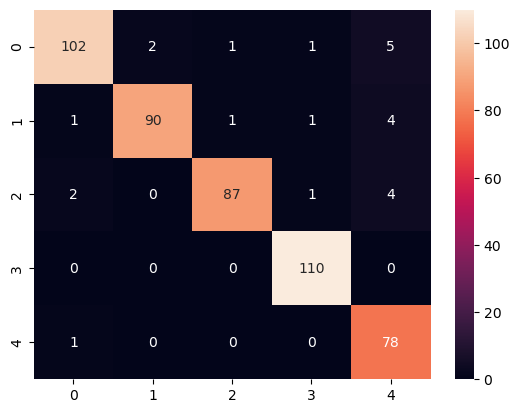

In [291]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d')

In [229]:
category = {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

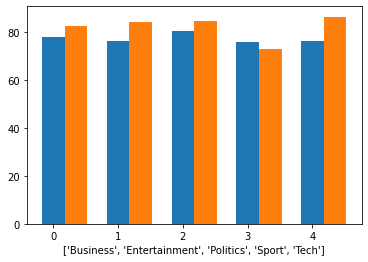

In [16]:
ExistingModel = [78.00341, 76.27842, 80.25695, 75.85361, 76.10006]
ProposedModel = [82.36892, 84.29505, 84.44507, 72.68903, 86.33905]
width = 0.35
index = ['Business', 'Entertainment', 'Politics', 'Sport', 'Tech'];

plot.bar(np.arange(len(ExistingModel)), ExistingModel, width=width)
plot.bar(np.arange(len(ProposedModel)) + width, ProposedModel, width=width)
plot.xlabel(index)
plot.show()
